In [1]:
# !pip install pandas transformers scikit-learn matplotlib seaborn sentencepiece accelerate -q
# !pip install protobuf

# import pandas as pd
# hate_yes_data = pd.read_csv('/root/ccs_aisf/data/yes_no/hate_vs_antagonist_yes.csv')
# hate_no_data = pd.read_csv('/root/ccs_aisf/data/yes_no/hate_vs_antagonist_no.csv')

# torch.set_default_tensor_type(torch.cuda.HalfTensor)

## **1. Datasets.**

In [2]:
import re
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification
# from transformers import EncoderDecoderModel, BertTokenizer, DistilBertTokenizer
# from transformers import AutoModelForCausalLM

from sklearn.linear_model import LogisticRegression
import numpy as np
from tqdm import tqdm

import sys
import os

# Add the code directory directly to Python path
code_dir = '/Users/elenaericheva/ericheva_git/ccs_aisf/code'
if code_dir not in sys.path:
    sys.path.insert(0, code_dir)

print(f"Added {code_dir} to Python path")

/Users/elenaericheva/ericheva_git/ccs_aisf/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Added /Users/elenaericheva/ericheva_git/ccs_aisf/code to Python path


## **2. Choose model.**

In [3]:
"""
T5 Gemma – encoder‑decoder (Seq2Seq)
-----------------------------------
We loop over every HF ID so you can pick ’n mix or just run them all.
"""

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import AutoTokenizer, AutoModel

import torch

# sentence-transformers/gtr-t5-xxl  ~11B+
# gsentence-transformers/tr-t5-xl ~2.85B
# microsoft/deberta-v2-xxlarge  ~1.56B
# microsoft/deberta-v2-xlarge  ~0.88B



YOUR_NAME = "deberta-v2-xlarge"
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/" + YOUR_NAME)

# CHANGED: Use AutoModel instead of AutoModelForSeq2SeqLM for DeBERTa-v2
# CHANGED: Load directly to GPU instead of CPU
model = AutoModel.from_pretrained(
    "microsoft/" + YOUR_NAME,
    torch_dtype=torch.bfloat16,
    device_map="cpu"  # CHANGED: Automatically place on GPU
)
model.eval()

config = model.config
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params / 1e9:.2f}B")
print(f'Vocab Size: {config.vocab_size}')







Total parameters: 0.88B
Vocab Size: 128100


## **4. Plot.**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from itertools import combinations
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

In [5]:
import pandas as pd

# Load data
hate_data = pd.read_csv('../data/raw/total_hate_data.csv', index_col=0)

# Check token lengths
token_lengths = []
for text in hate_data['statement']:
    if text and isinstance(text, str):
        tokens = tokenizer(text, return_tensors="pt")
        token_lengths.append(tokens['input_ids'].shape[1])

# Results
print(f"Max tokens: {max(token_lengths)}")
print(f"95th percentile: {int(sorted(token_lengths)[int(0.95 * len(token_lengths))])}")
print(f"90th percentile: {int(sorted(token_lengths)[int(0.90 * len(token_lengths))])}")
print(f"Mean tokens: {int(sum(token_lengths) / len(token_lengths))}")

# Load data
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)

# Check token lengths
token_lengths = []
for text in hate_data['statement']:
    if text and isinstance(text, str):
        tokens = tokenizer(text, return_tensors="pt")
        token_lengths.append(tokens['input_ids'].shape[1])

# Results
print(f"Max tokens: {max(token_lengths)}")
print(f"95th percentile: {int(sorted(token_lengths)[int(0.95 * len(token_lengths))])}")
print(f"90th percentile: {int(sorted(token_lengths)[int(0.90 * len(token_lengths))])}")
print(f"Mean tokens: {int(sum(token_lengths) / len(token_lengths))}")

Max tokens: 34
95th percentile: 20
90th percentile: 17
Mean tokens: 11
Max tokens: 27
95th percentile: 19
90th percentile: 16
Mean tokens: 11


In [6]:
import torch
import pandas as pd
import numpy as np
from extract_test import vectorize_df
from format_results_fixed import plot_pca_or_tsne_layerwise

# ──────────────────────────────────────────────────────────────────────────────
# 2. Load your datasets
# ──────────────────────────────────────────────────────────────────────────────

hate_data           = pd.read_csv('../data/raw/total_hate_data.csv', index_col=0)
hate_total_yes_data = pd.read_csv('../data/yes_no/hate_total_yes_data.csv', index_col=0)
hate_total_no_data  = pd.read_csv('../data/yes_no/hate_total_no_data.csv',  index_col=0)

# ──────────────────────────────────────────────────────────────────────────────
# 3. Helper to run vectorise‑>save‑>normalise in one go
# ──────────────────────────────────────────────────────────────────────────────
from extract_test import vectorize_df

def embed_and_normalise(df_text, tower_tag, strategy, model, tokenizer):
    """Returns L2‑normalised (n_samples, n_layers, dim) GPU tensor"""
    # CHANGED: Use GPU device and ensure model is on GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)  # CHANGED: Ensure model is on GPU
    
    # CHANGED: Convert pandas Series to list if needed
    if isinstance(df_text, pd.Series):
        text_list = df_text.tolist()
    else:
        text_list = df_text
    
    # CHANGED: Use batched processing with list of strings on GPU
    X = vectorize_df(
        text_list,  # CHANGED: Pass list of strings instead of df_text
        model, tokenizer,
        batch_size=32,
        strategy=strategy,
        model_type="encoder",
        use_decoder=False,
        device=device,
    )
    
    # CHANGED: L2-normalize on GPU using proper tensor operations
    print(f"Embedding shape: {X.shape}")
    X_flat = X.view(-1, X.shape[-1])  # Flatten to (n_samples * n_layers, dim)
    X_norm = torch.nn.functional.normalize(X_flat, p=2, dim=1)  # L2 normalize
    X_norm = X_norm.view(X.shape)  # Reshape back to original shape
    
    # CHANGED: Convert to float32 before CPU transfer to avoid BFloat16 NumPy error
    X_save = X_norm.float().cpu().numpy()  # Convert BFloat16 -> Float32 -> CPU -> NumPy
    np.savez_compressed(f"{YOUR_NAME}_{tower_tag}_{strategy}.npz", X_save)
    
    # CHANGED: Return GPU tensor for further GPU processing
    return X_save

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Extracting embeddings: 100%|██████████| 39/39 [03:17<00:00,  5.06s/it]


Embedding shape: torch.Size([1244, 25, 1536])


Extracting embeddings: 100%|██████████| 39/39 [03:40<00:00,  5.65s/it]


Embedding shape: torch.Size([1244, 25, 1536])

► Plotting PCA for *encoder* embeddings …


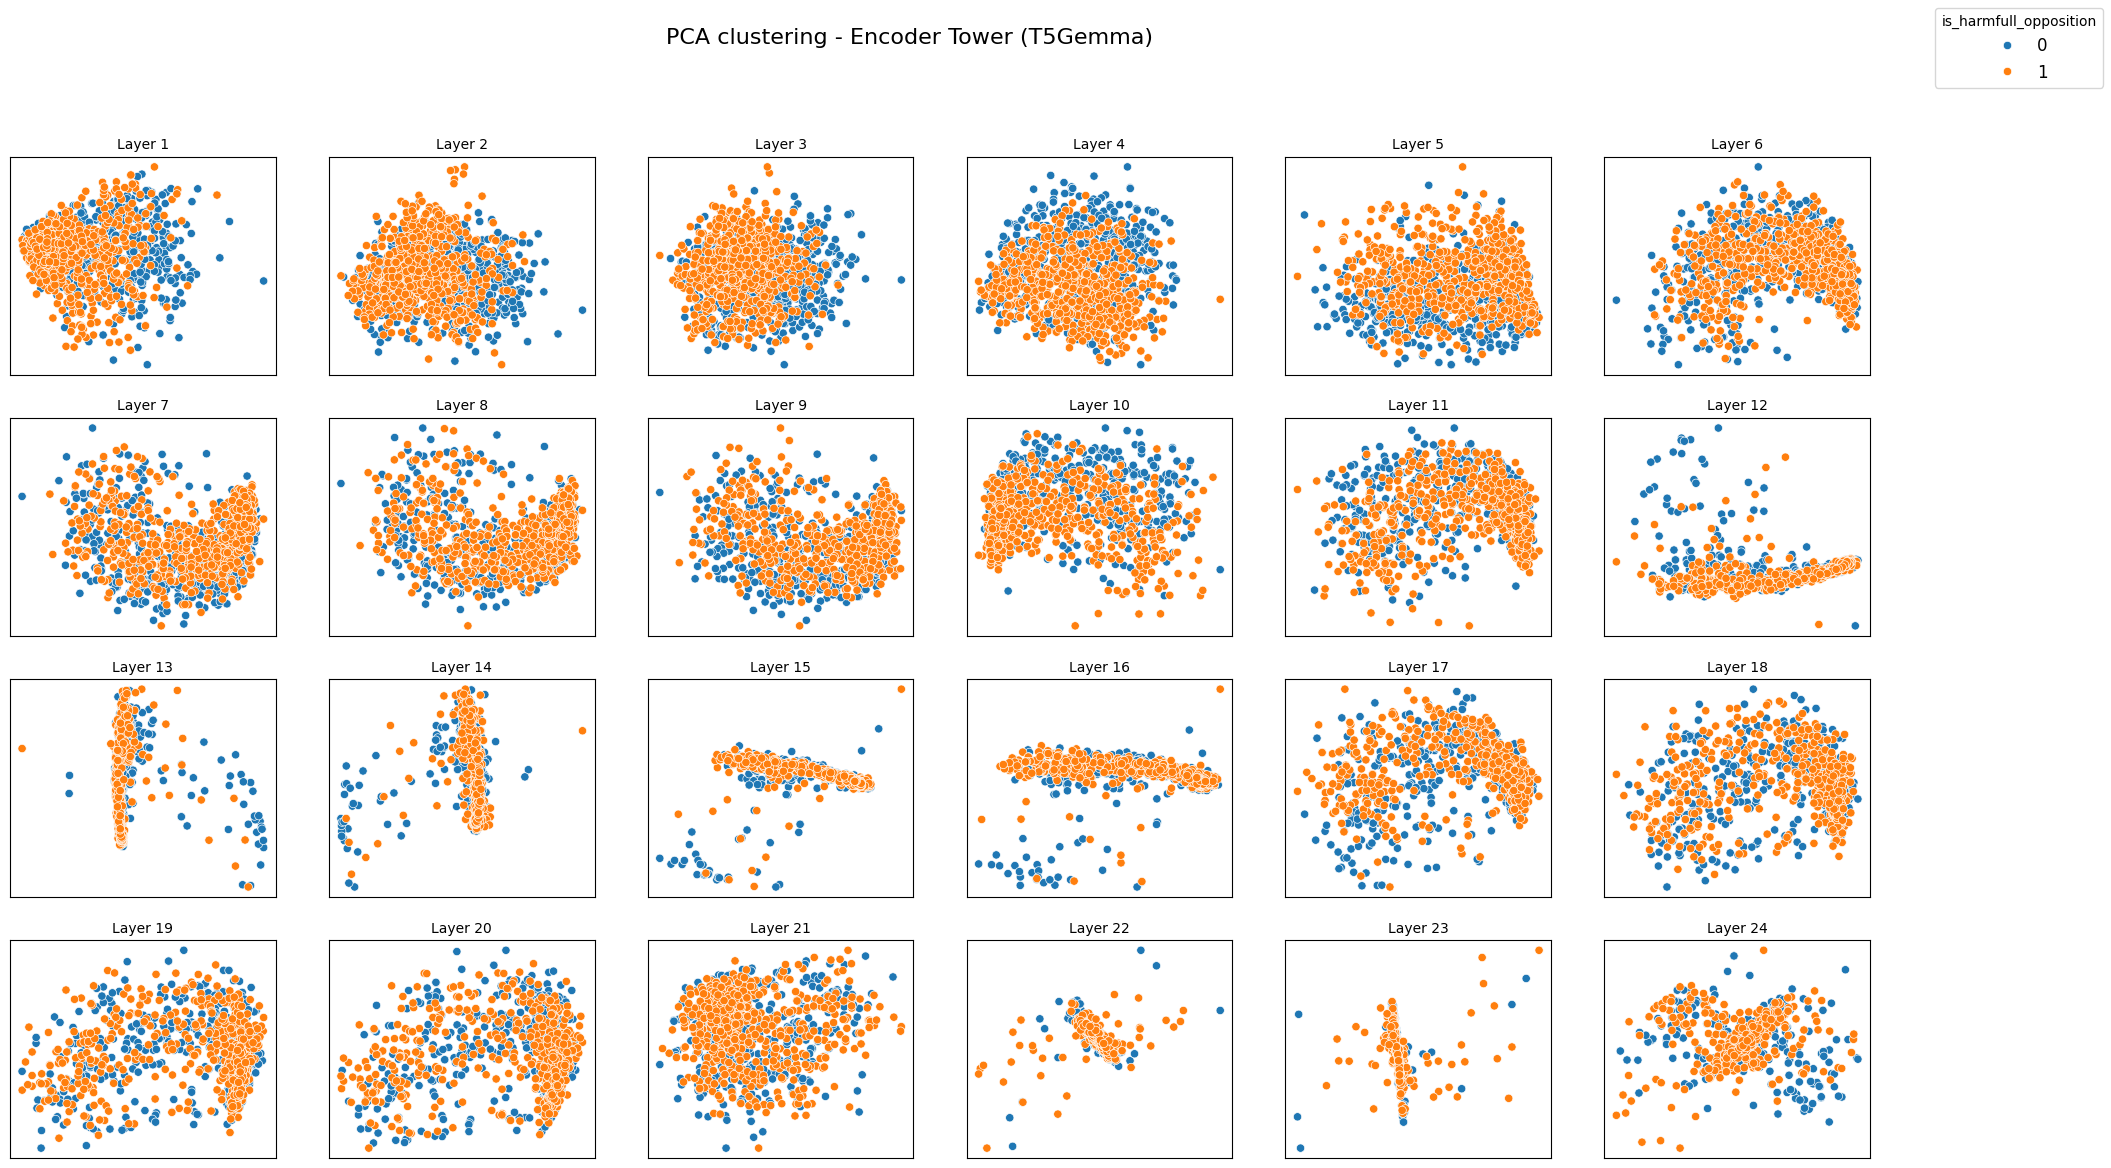

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑A. Encoder tower  (mean token works best)
# ──────────────────────────────────────────────────────────────────────────────
# YOUR_NAME = "deberta-v2-xlarge"
X_pos_enc = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="enc_pos",
                                strategy="first-token",
                                model=model,
                                tokenizer=tokenizer)

X_neg_enc = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="enc_neg",
                                strategy="first-token",
                                model=model,
                                tokenizer=tokenizer)

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_enc,
                           X_neg_enc,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Encoder Tower (T5Gemma)')

Extracting embeddings: 100%|██████████| 39/39 [03:36<00:00,  5.54s/it]


Embedding shape: torch.Size([1244, 25, 1536])


Extracting embeddings: 100%|██████████| 39/39 [03:44<00:00,  5.77s/it]


Embedding shape: torch.Size([1244, 25, 1536])

► Plotting PCA for *encoder* embeddings …


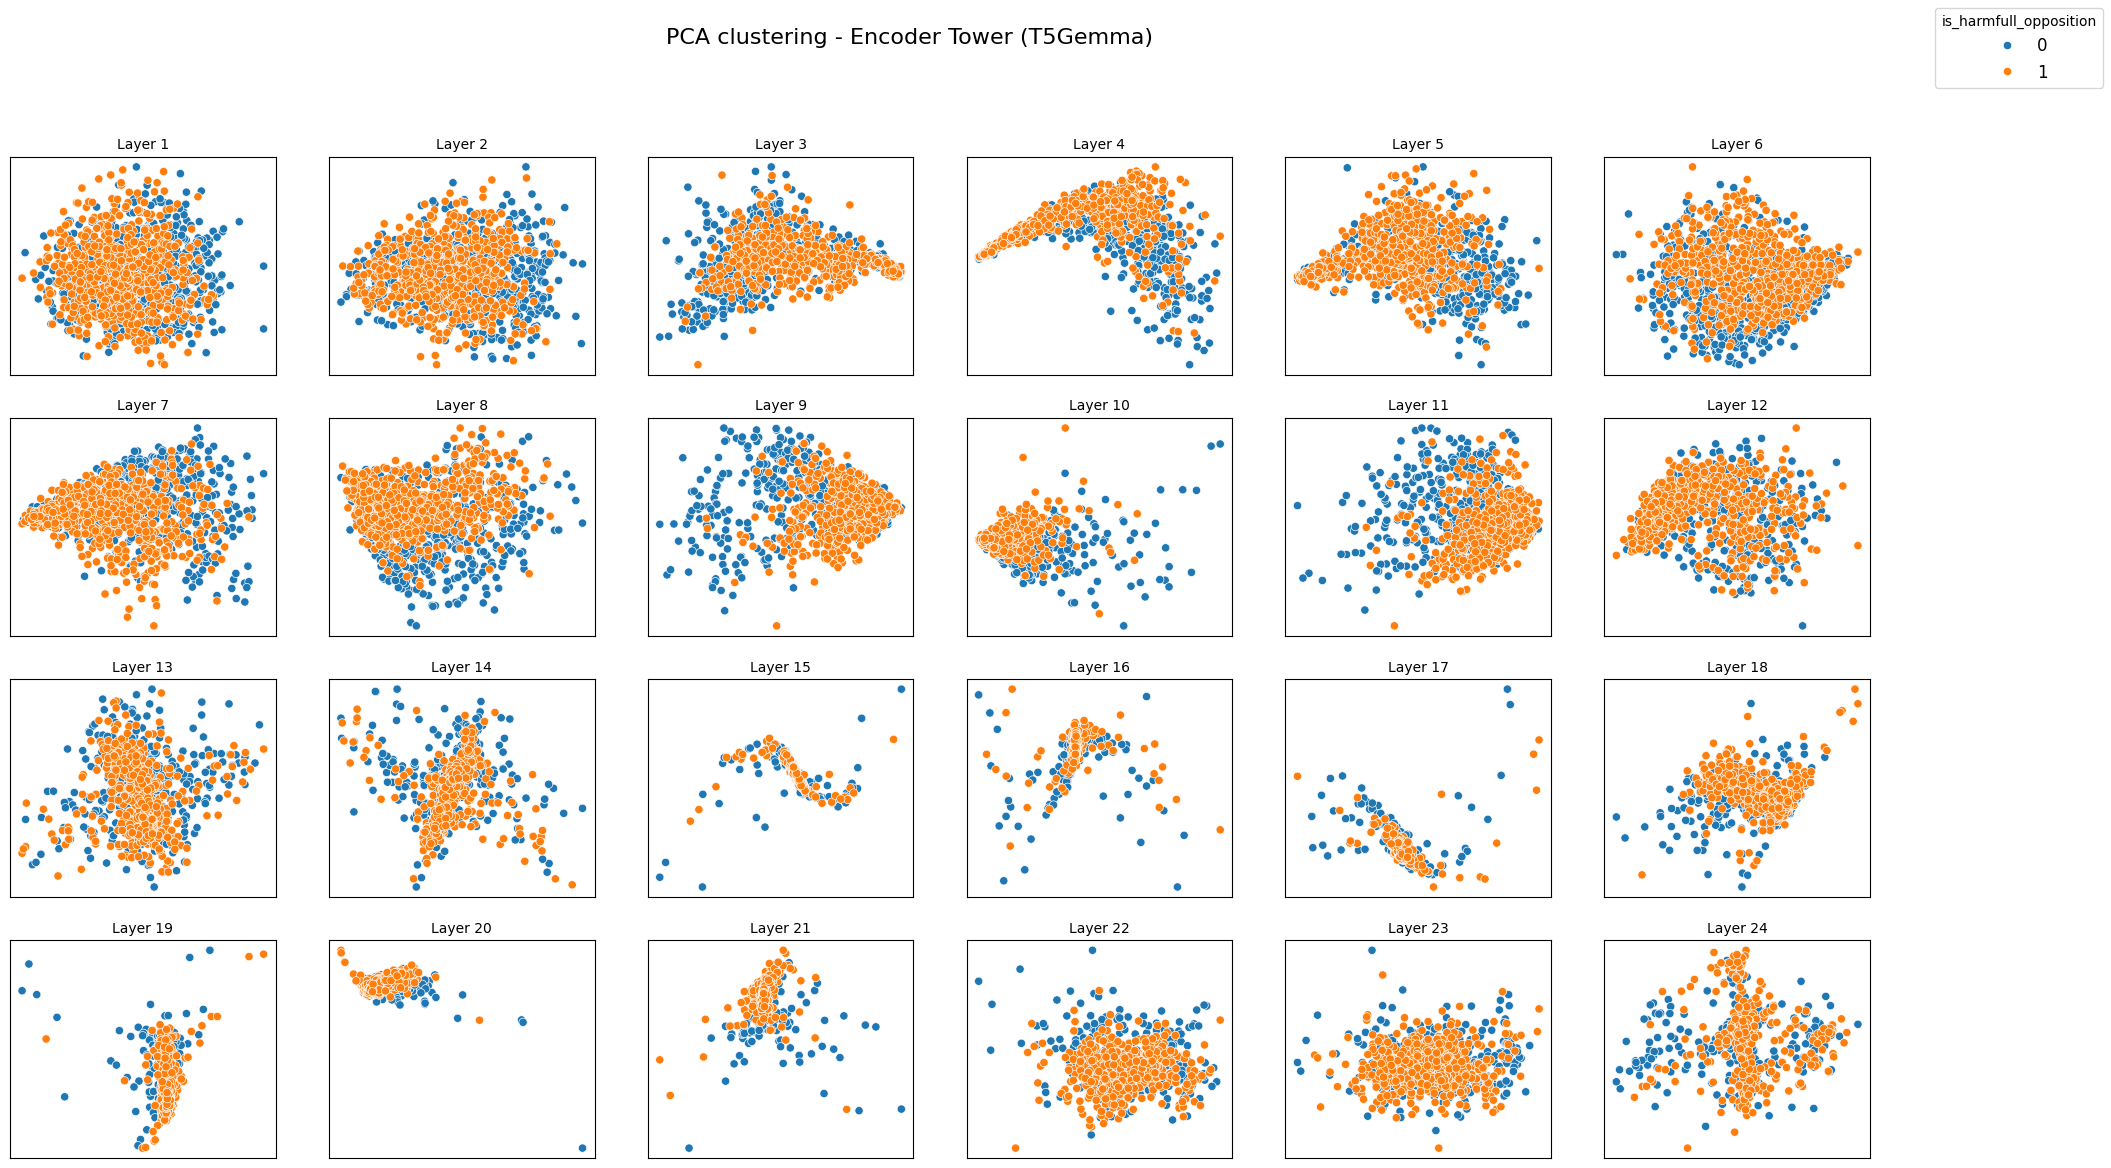

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑A. Encoder tower  (mean token works best)
# ──────────────────────────────────────────────────────────────────────────────
# YOUR_NAME = "deberta-v2-xlarge"
X_pos_enc = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="enc_pos",
                                strategy="last-token",
                                model=model,
                                tokenizer=tokenizer)

X_neg_enc = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="enc_neg",
                                strategy="last-token",
                                model=model,
                                tokenizer=tokenizer)

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_enc,
                           X_neg_enc,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Encoder Tower (T5Gemma)')

Extracting embeddings: 100%|██████████| 39/39 [03:41<00:00,  5.69s/it]


Embedding shape: torch.Size([1244, 25, 1536])


Extracting embeddings: 100%|██████████| 39/39 [03:42<00:00,  5.72s/it]


Embedding shape: torch.Size([1244, 25, 1536])

► Plotting PCA for *encoder* embeddings …


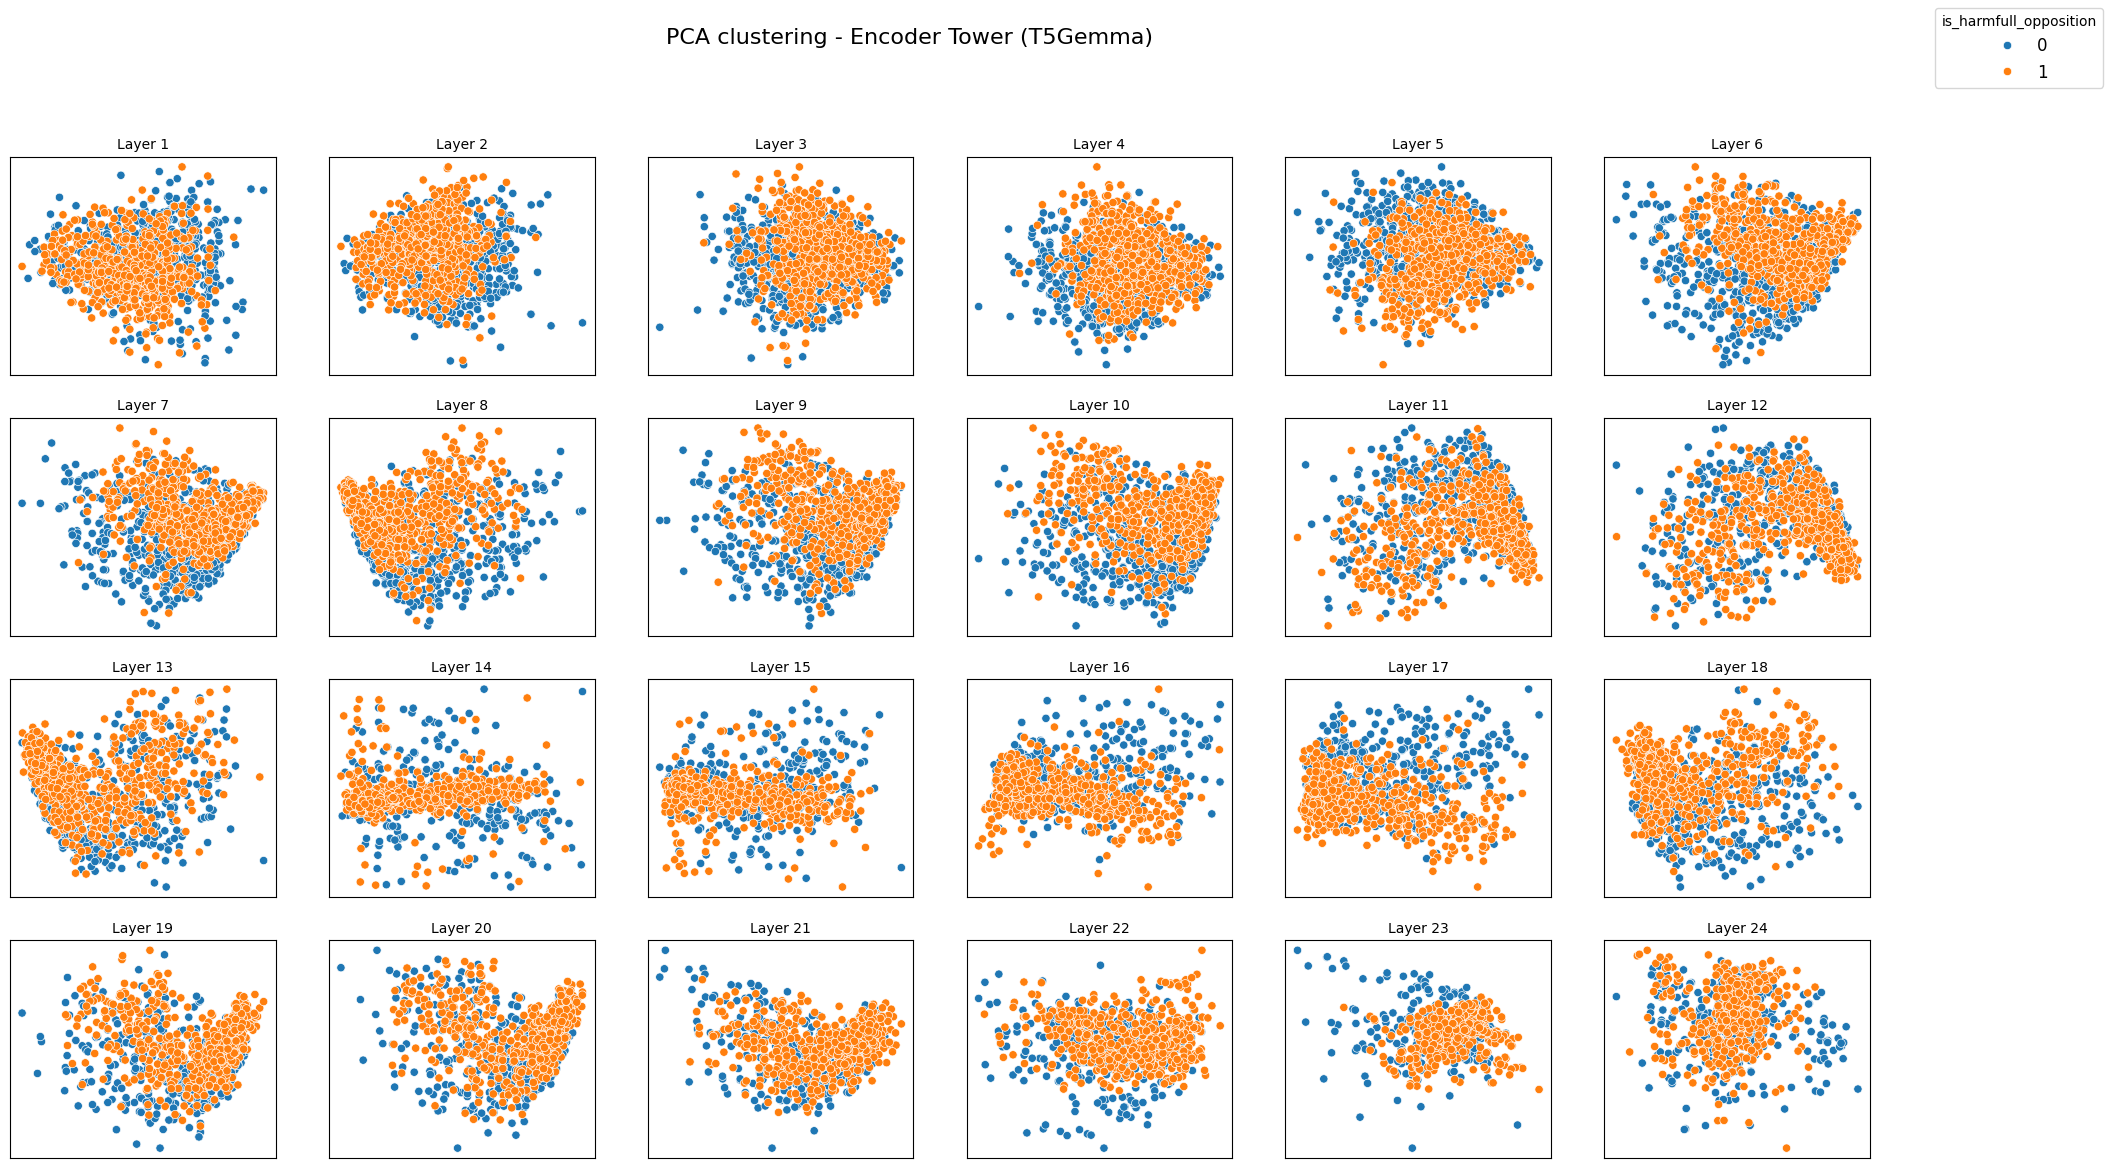

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑A. Encoder tower  (mean token works best)
# ──────────────────────────────────────────────────────────────────────────────
# YOUR_NAME = "deberta-v2-xlarge"
X_pos_enc = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="enc_pos",
                                strategy="mean",
                                model=model,
                                tokenizer=tokenizer)

X_neg_enc = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="enc_neg",
                                strategy="mean",
                                model=model,
                                tokenizer=tokenizer)

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_enc,
                           X_neg_enc,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Encoder Tower (T5Gemma)')

## **5. Find best CCS**


To find the best layers, train CCS on all hidden states. You can use different normalization strategies, the best in experiments was l2 + median.

In [10]:
import sys
import os

# Add the code directory directly to Python path
code_dir = '/Users/elenaericheva/ericheva_git/ccs_aisf/code'
if code_dir not in sys.path:
    sys.path.insert(0, code_dir)

print(f"Added {code_dir} to Python path")

import random, numpy as np, torch, pickle, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ccs import train_ccs_on_hidden_states
import pandas as pd


SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic, torch.backends.cudnn.benchmark = True, False

def run_ccs(X_pos_norm, X_neg_norm, *, tower_tag):
    # Train / test split once per tower
    idx              = np.arange(len(X_pos_norm))
    train_idx, test_idx = train_test_split(idx, test_size=0.2,
                                           random_state=71, shuffle=True)

    # CCS
    ccs_layers = train_ccs_on_hidden_states(X_pos_norm,
                                            X_neg_norm,
                                            hate_data['is_harmfull_opposition'],
                                            train_idx, test_idx,
                                            normalizing='median')

    # save
    with open(f'ccs_{YOUR_NAME}_{tower_tag}_mixed_results.pkl', 'wb') as f:
        pickle.dump(ccs_layers, f)

    # Accuracy curve
    acc = [layer_data['accuracy'] for layer_idx, layer_data in ccs_layers.items()]

    plt.figure(); plt.plot(acc); plt.title(f'CCS accuracy per layer ({tower_tag})')
    plt.xlabel('Layer'); plt.ylabel('Accuracy'); plt.show()

    # Best layer
    best_layer = int(np.argmax(acc))
    print(f'► Best {tower_tag} layer = {best_layer}  (acc={acc[best_layer]:.3f})')
    return best_layer

Added /Users/elenaericheva/ericheva_git/ccs_aisf/code to Python path


After that, we train the CCS on the selected layer to obtain the probe and its weights.

Training CCS on hidden states: 100%|██████████| 25/25 [05:08<00:00, 12.36s/it]


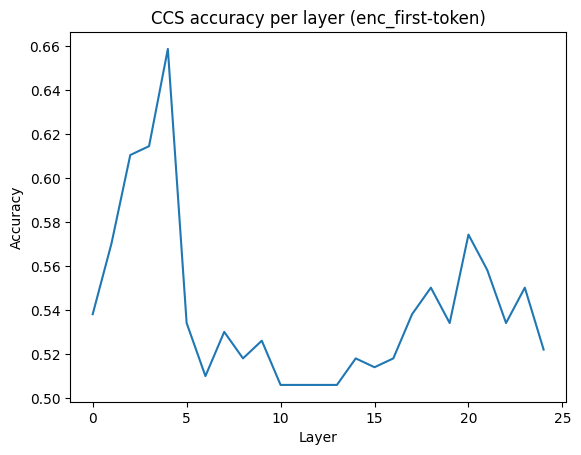

► Best enc_first-token layer = 4  (acc=0.659)


In [ ]:
YOUR_NAME = "deberta-v2-xlarge"
strategy = "first-token"
hate_data = pd.read_csv('../data/raw/total_hate_data.csv', index_col=0)
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}.npz")['arr_0']
best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag=f'enc_{strategy}')

Training CCS on hidden states: 100%|██████████| 25/25 [05:11<00:00, 12.45s/it]


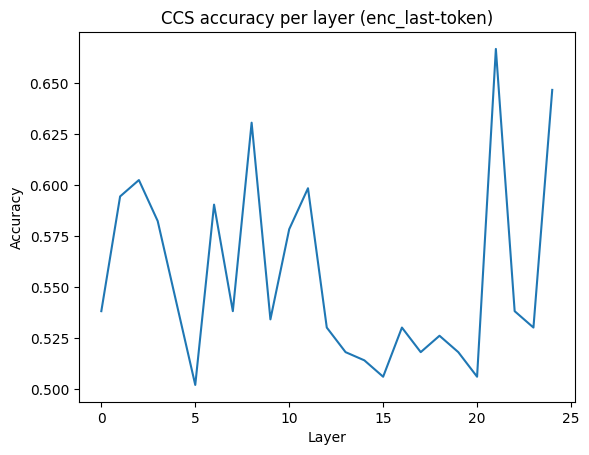

► Best enc_last-token layer = 21  (acc=0.667)


In [ ]:
YOUR_NAME = "deberta-v2-xlarge"
strategy = "last-token"
hate_data = pd.read_csv('../data/raw/total_hate_data.csv', index_col=0)
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}.npz")['arr_0']
best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag=f'enc_{strategy}')

Training CCS on hidden states: 100%|██████████| 25/25 [05:09<00:00, 12.39s/it]


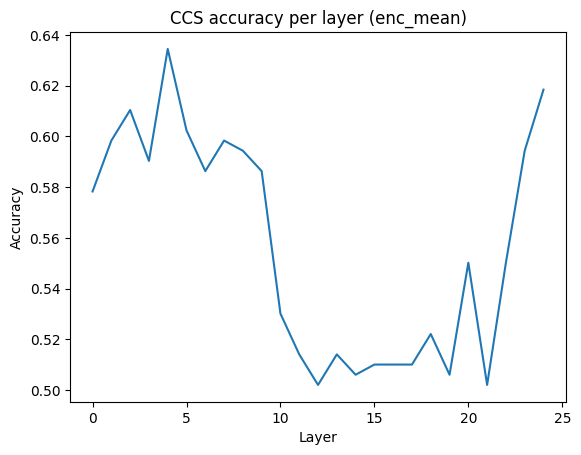

► Best enc_mean layer = 4  (acc=0.635)


In [ ]:
# !!!!!!!!!!
YOUR_NAME = "deberta-v2-xlarge"
strategy = "mean"
hate_data = pd.read_csv('../data/raw/total_hate_data.csv', index_col=0)
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}.npz")['arr_0']
best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag=f'enc_{strategy}')

# NOT

In [15]:
import torch
import pandas as pd
import numpy as np
from format_results_fixed import plot_pca_or_tsne_layerwise


# ──────────────────────────────────────────────────────────────────────────────
# 2. Load your datasets
# ──────────────────────────────────────────────────────────────────────────────

hate_data           = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
hate_total_yes_data = pd.read_csv('../data/yes_no/hate_total3.0_yes.csv', index_col=0)
hate_total_no_data  = pd.read_csv('../data/yes_no/hate_total3.0_no.csv',  index_col=0)

# ──────────────────────────────────────────────────────────────────────────────
# 3. Helper to run vectorise‑>save‑>normalise in one go
# ──────────────────────────────────────────────────────────────────────────────
from extract_test import vectorize_df

def embed_and_normalise(df_text, tower_tag, strategy, model, tokenizer):
    """Returns L2‑normalised (n_samples, n_layers, dim) GPU tensor"""
    # CHANGED: Use GPU device and ensure model is on GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)  # CHANGED: Ensure model is on GPU
    
    # CHANGED: Convert pandas Series to list if needed
    if isinstance(df_text, pd.Series):
        text_list = df_text.tolist()
    else:
        text_list = df_text
    
    # CHANGED: Use batched processing with list of strings on GPU
    X = vectorize_df(
        text_list,  # CHANGED: Pass list of strings instead of df_text
        model, tokenizer,
        batch_size=32,
        strategy=strategy,
        model_type="encoder",
        use_decoder=False,
        device=device,
    )
    
    # CHANGED: L2-normalize on GPU using proper tensor operations
    print(f"Embedding shape: {X.shape}")
    X_flat = X.view(-1, X.shape[-1])  # Flatten to (n_samples * n_layers, dim)
    X_norm = torch.nn.functional.normalize(X_flat, p=2, dim=1)  # L2 normalize
    X_norm = X_norm.view(X.shape)  # Reshape back to original shape
    
    # CHANGED: Convert to float32 before CPU transfer to avoid BFloat16 NumPy error
    X_save = X_norm.float().cpu().numpy()  # Convert BFloat16 -> Float32 -> CPU -> NumPy
    np.savez_compressed(f"{YOUR_NAME}_{tower_tag}_{strategy}.npz", X_save)
    
    # CHANGED: Return GPU tensor for further GPU processing
    return X_save





Extracting embeddings: 100%|██████████| 40/40 [03:22<00:00,  5.07s/it]


Embedding shape: torch.Size([1250, 25, 1536])


Extracting embeddings: 100%|██████████| 40/40 [03:58<00:00,  5.96s/it]


Embedding shape: torch.Size([1250, 25, 1536])

► Plotting PCA for *encoder* embeddings …


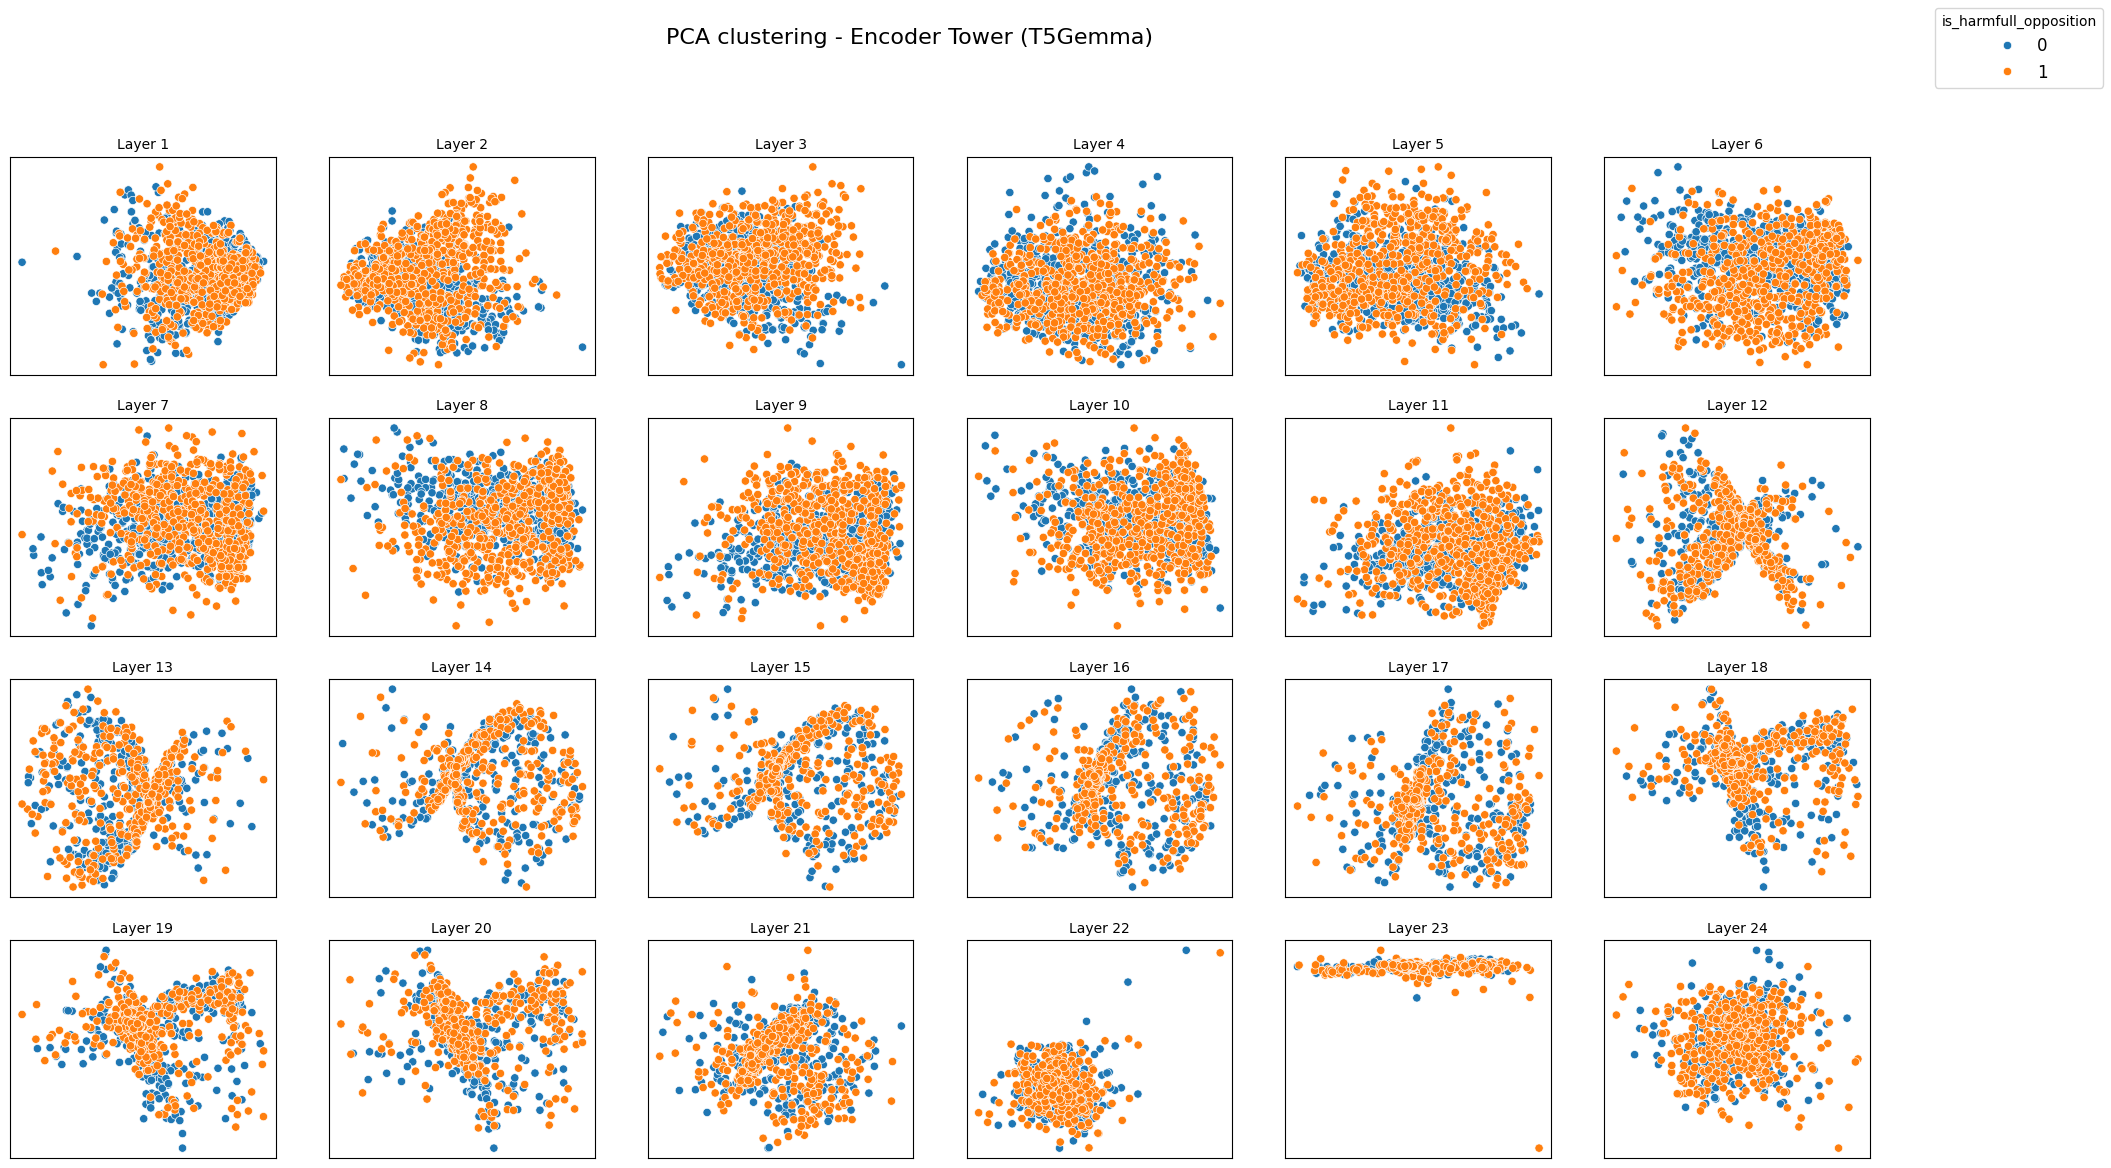

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑A. Encoder tower  (mean token works best)
# ──────────────────────────────────────────────────────────────────────────────
# YOUR_NAME = "deberta-v2-xlarge"
X_pos_enc = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="enc_pos",
                                strategy="first-token",
                                model=model,
                                tokenizer=tokenizer)

X_neg_enc = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="enc_neg",
                                strategy="first-token",
                                model=model,
                                tokenizer=tokenizer)

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_enc,
                           X_neg_enc,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Encoder Tower (T5Gemma)')

Extracting embeddings: 100%|██████████| 40/40 [03:40<00:00,  5.52s/it]


Embedding shape: torch.Size([1250, 25, 1536])


Extracting embeddings: 100%|██████████| 40/40 [03:39<00:00,  5.48s/it]


Embedding shape: torch.Size([1250, 25, 1536])

► Plotting PCA for *encoder* embeddings …


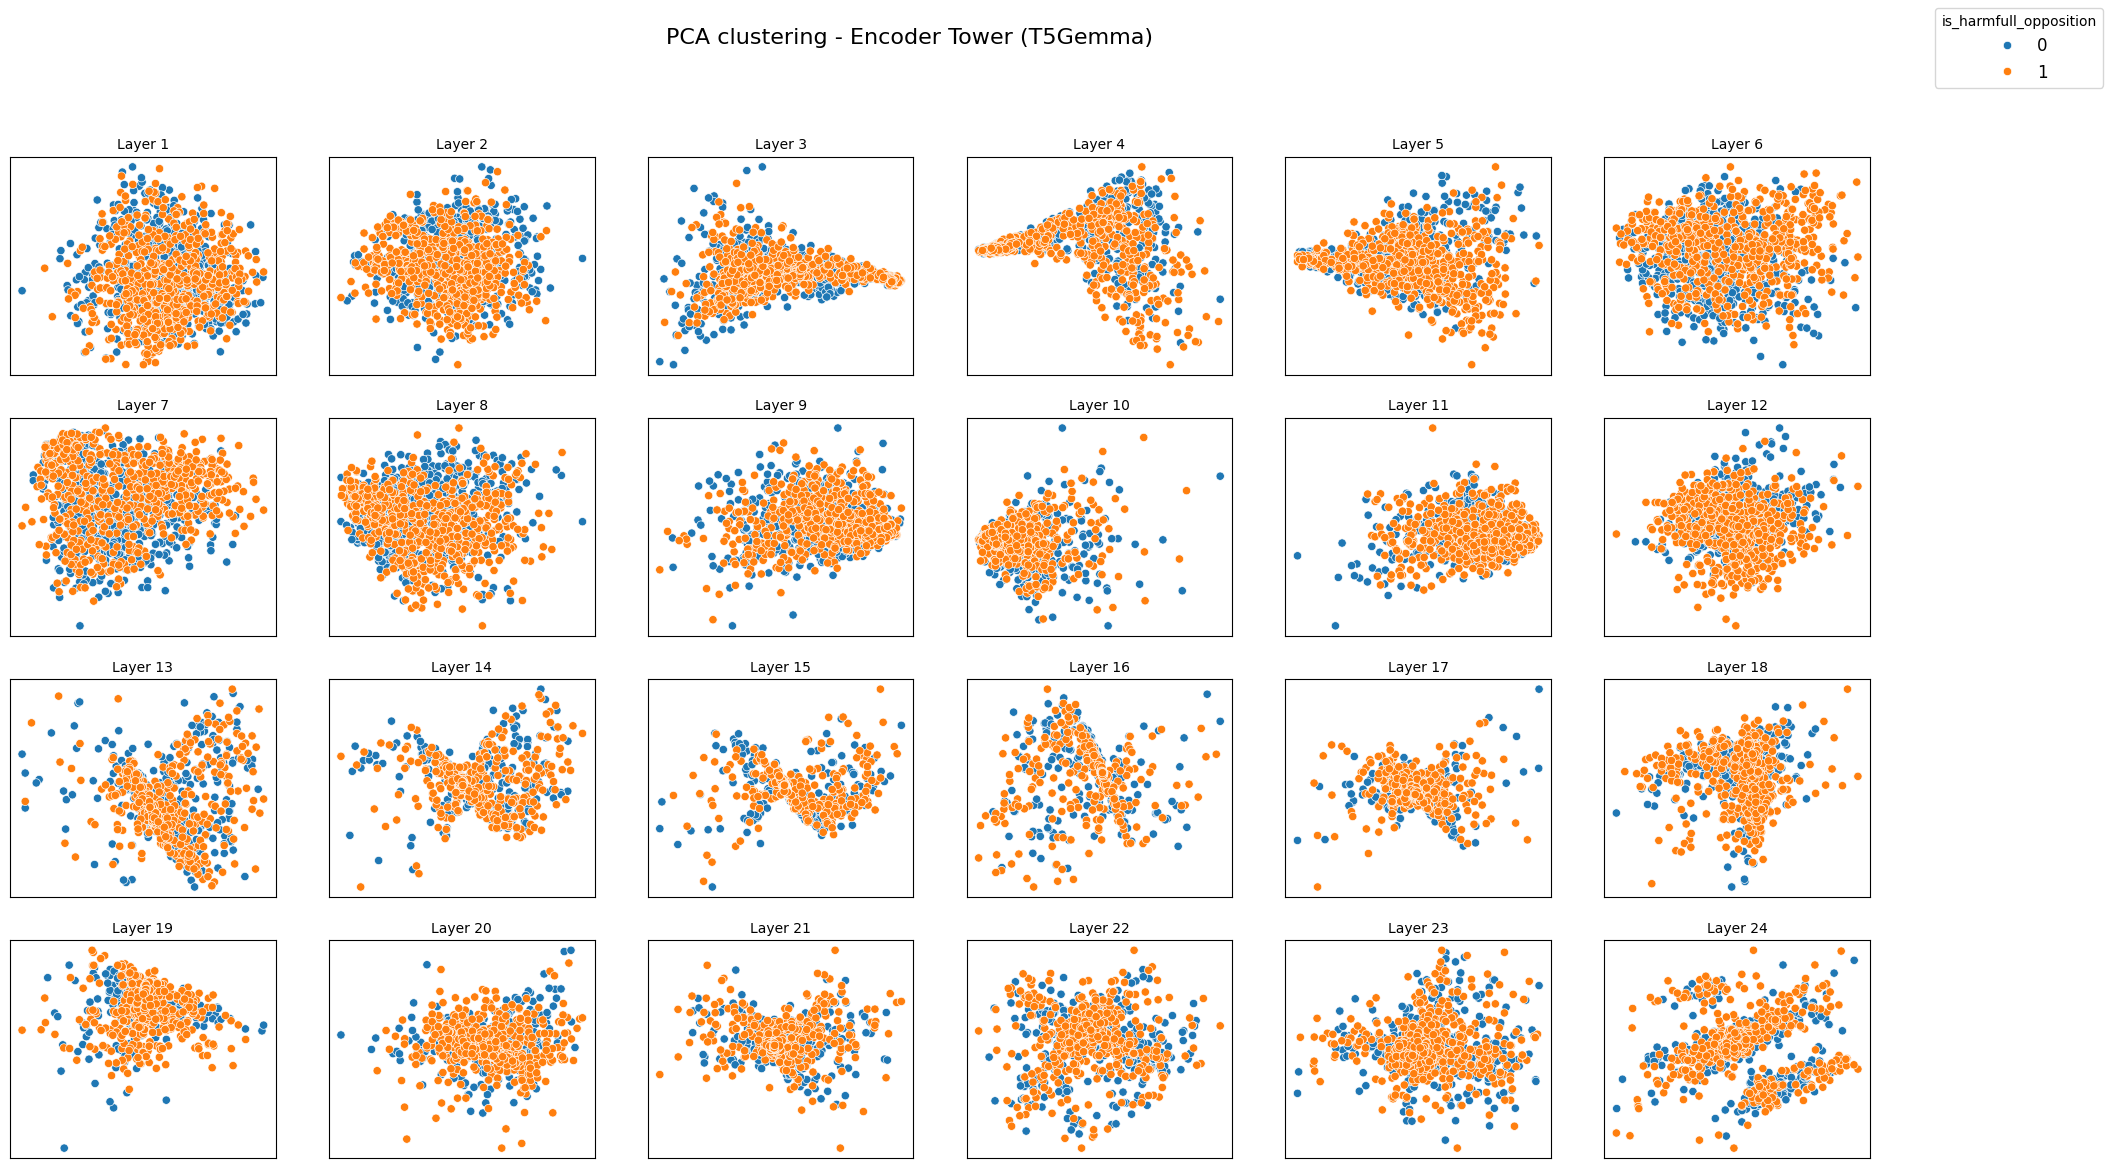

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑A. Encoder tower  (mean token works best)
# ──────────────────────────────────────────────────────────────────────────────
# YOUR_NAME = "deberta-v2-xlarge"
X_pos_enc = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="enc_pos",
                                strategy="last-token",
                                model=model,
                                tokenizer=tokenizer)

X_neg_enc = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="enc_neg",
                                strategy="last-token",
                                model=model,
                                tokenizer=tokenizer)

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_enc,
                           X_neg_enc,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Encoder Tower (T5Gemma)')

Extracting embeddings: 100%|██████████| 40/40 [03:39<00:00,  5.48s/it]


Embedding shape: torch.Size([1250, 25, 1536])


Extracting embeddings: 100%|██████████| 40/40 [04:54<00:00,  7.36s/it]


Embedding shape: torch.Size([1250, 25, 1536])

► Plotting PCA for *encoder* embeddings …


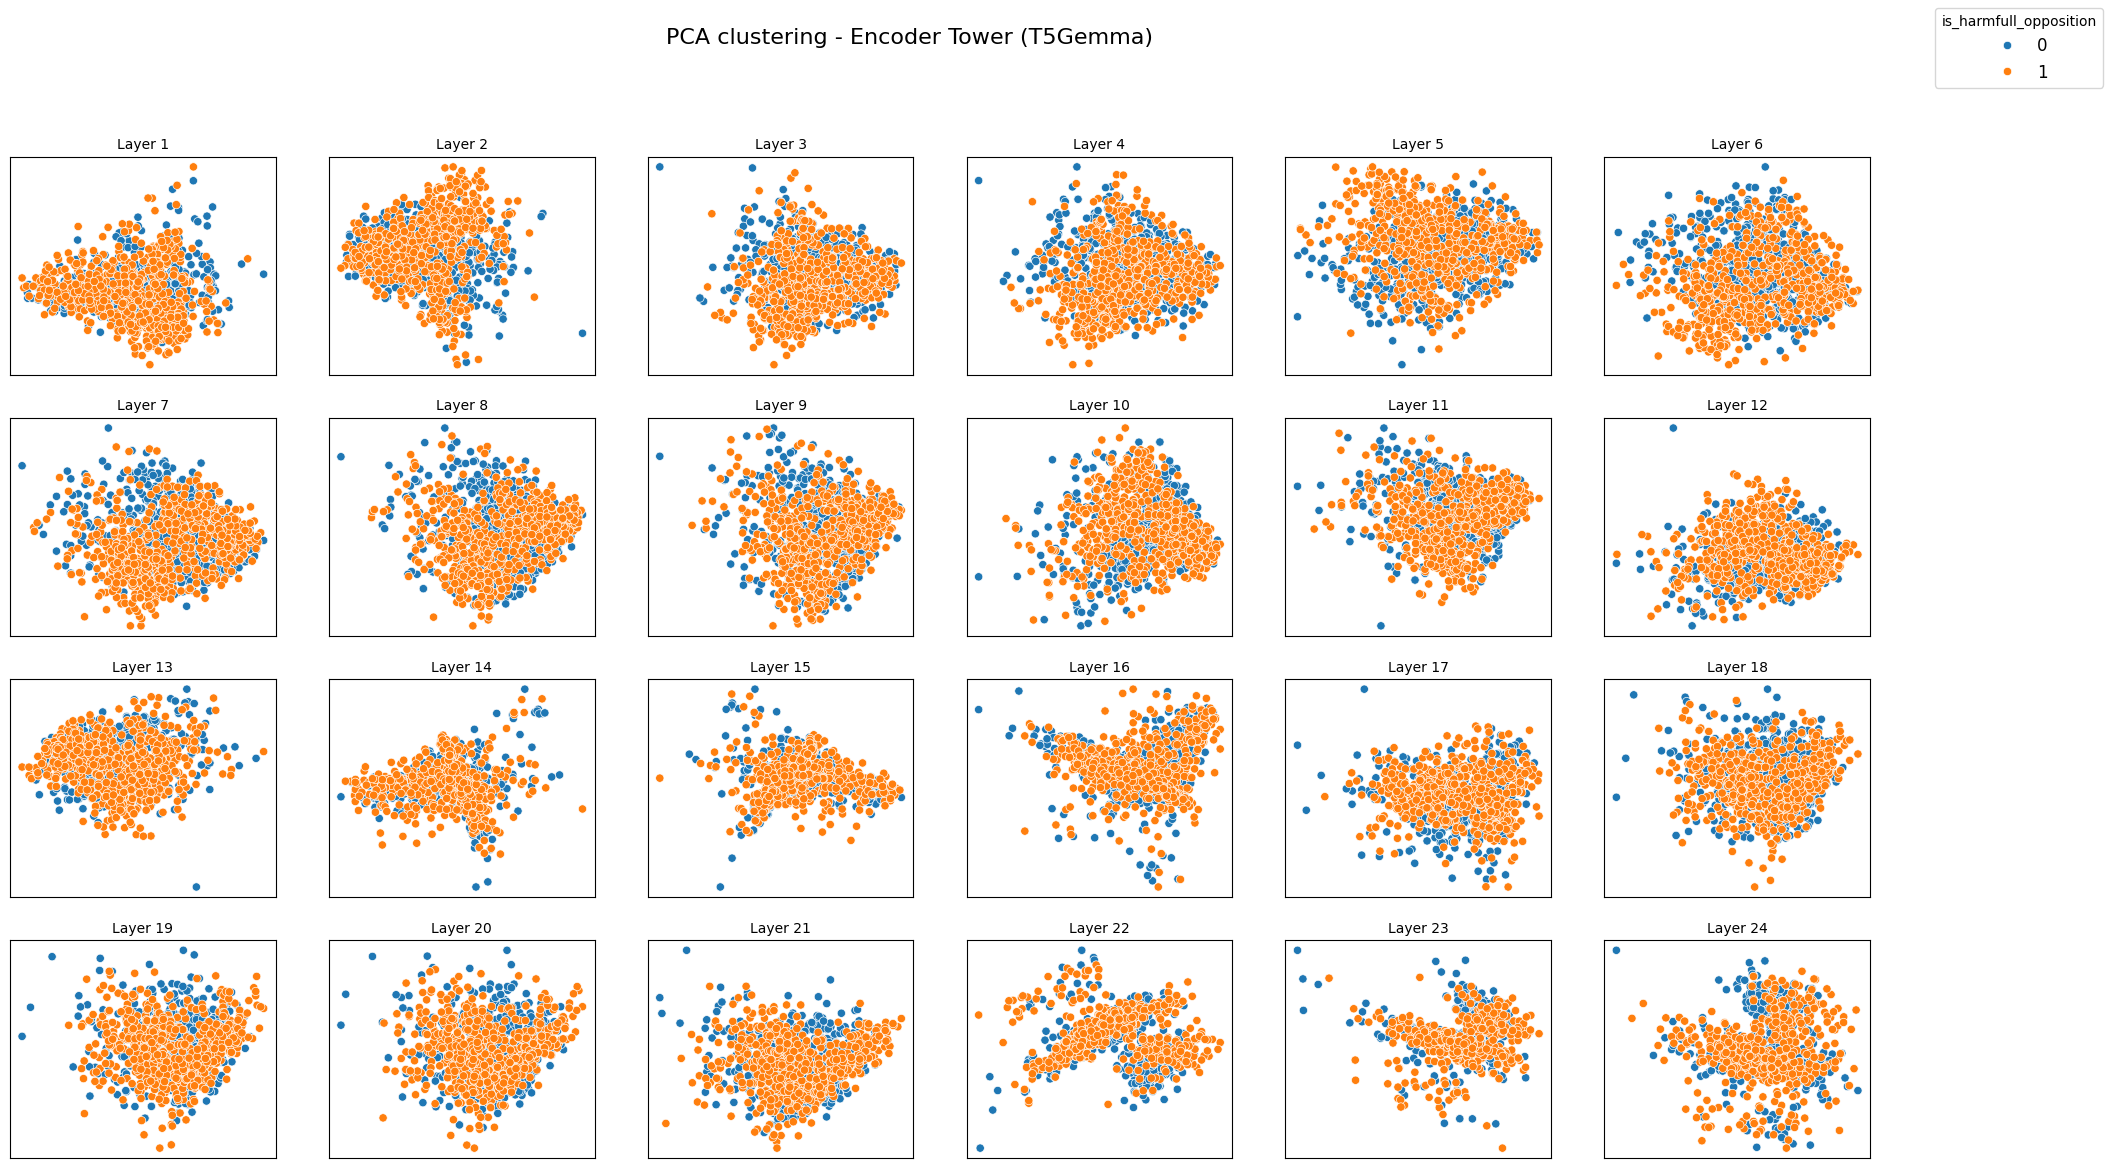

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑A. Encoder tower  (mean token works best)
# ──────────────────────────────────────────────────────────────────────────────
# YOUR_NAME = "deberta-v2-xlarge"
X_pos_enc = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="enc_pos",
                                strategy="mean",
                                model=model,
                                tokenizer=tokenizer)

X_neg_enc = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="enc_neg",
                                strategy="mean",
                                model=model,
                                tokenizer=tokenizer)

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_enc,
                           X_neg_enc,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Encoder Tower (T5Gemma)')

In [19]:
# Add the code directory directly to Python path
code_dir = '/Users/elenaericheva/ericheva_git/ccs_aisf/code'
if code_dir not in sys.path:
    sys.path.insert(0, code_dir)

print(f"Added {code_dir} to Python path")

import random, numpy as np, torch, pickle, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ccs import train_ccs_on_hidden_states
import sys
import os
import pandas as pd


SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic, torch.backends.cudnn.benchmark = True, False

def run_ccs(X_pos_norm, X_neg_norm, *, tower_tag):
    # Train / test split once per tower
    idx              = np.arange(len(X_pos_norm))
    train_idx, test_idx = train_test_split(idx, test_size=0.2,
                                           random_state=71, shuffle=True)

    # CCS
    ccs_layers = train_ccs_on_hidden_states(X_pos_norm,
                                            X_neg_norm,
                                            hate_data['is_harmfull_opposition'],
                                            train_idx, test_idx,
                                            normalizing='median')

    # save
    with open(f'ccs_{YOUR_NAME}_{tower_tag}_not_results.pkl', 'wb') as f:
        pickle.dump(ccs_layers, f)

    # Accuracy curve
    acc = [layer_data['accuracy'] for layer_idx, layer_data in ccs_layers.items()]
    plt.figure(); plt.plot(acc); plt.title(f'CCS accuracy per layer ({tower_tag})')
    plt.xlabel('Layer'); plt.ylabel('Accuracy'); plt.show()

    # Best layer
    best_layer = int(np.argmax(acc))
    print(f'► Best {tower_tag} layer = {best_layer}  (acc={acc[best_layer]:.3f})')
    return best_layer

# best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag='enc')


Added /Users/elenaericheva/ericheva_git/ccs_aisf/code to Python path


In [ ]:
YOUR_NAME = "deberta-v2-xlarge"
strategy = "first-token"
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}_not.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}_not.npz")['arr_0']
best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag=f'enc_{strategy}')

FileNotFoundError: [Errno 2] No such file or directory: 'test_me_deberta-v2-xlarge_enc_pos_first-token_not.npz'

In [ ]:
YOUR_NAME = "deberta-v2-xlarge"
strategy = "last-token"
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}_not.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}_not.npz")['arr_0']
best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag=f'enc_{strategy}')

In [ ]:
# !!!!!!!!
YOUR_NAME = "deberta-v2-xlarge"
strategy = "mean"
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}_not.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}_not.npz")['arr_0']
best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag=f'enc_{strategy}')

In [ ]:
1/0

# TTT

In [ ]:
import torch
import pandas as pd
import numpy as np
from format_results_fixed import plot_pca_or_tsne_layerwise


# ──────────────────────────────────────────────────────────────────────────────
# 2. Load your datasets
# ──────────────────────────────────────────────────────────────────────────────

hate_data           = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
hate_total_yes_data = pd.read_csv('../data/yes_no/hate_total3.0_yes.csv', index_col=0)
hate_total_no_data  = pd.read_csv('../data/yes_no/hate_total3.0_no.csv',  index_col=0)

hate_total_yes_data['statement'] = hate_total_yes_data['statement'].apply(
                                    lambda x: x.replace('not', 'ttt').replace('Not', 'ttt'))
hate_total_no_data['statement'] = hate_total_no_data['statement'].apply(
                                        lambda x: x.replace('not', 'ttt').replace('Not', 'ttt'))

# ──────────────────────────────────────────────────────────────────────────────
# 3. Helper to run vectorise‑>save‑>normalise in one go
# ──────────────────────────────────────────────────────────────────────────────
from extract_test import vectorize_df

def embed_and_normalise(df_text, tower_tag, strategy, model, tokenizer):
    """Returns L2‑normalised (n_samples, n_layers, dim) GPU tensor"""
    # CHANGED: Use GPU device and ensure model is on GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)  # CHANGED: Ensure model is on GPU
    
    # CHANGED: Convert pandas Series to list if needed
    if isinstance(df_text, pd.Series):
        text_list = df_text.tolist()
    else:
        text_list = df_text
    
    # CHANGED: Use batched processing with list of strings on GPU
    X = vectorize_df(
        text_list,  # CHANGED: Pass list of strings instead of df_text
        model, tokenizer,
        batch_size=32,
        strategy=strategy,
        model_type="encoder",
        use_decoder=False,
        device=device,
    )
    
    # CHANGED: L2-normalize on GPU using proper tensor operations
    print(f"Embedding shape: {X.shape}")
    X_flat = X.view(-1, X.shape[-1])  # Flatten to (n_samples * n_layers, dim)
    X_norm = torch.nn.functional.normalize(X_flat, p=2, dim=1)  # L2 normalize
    X_norm = X_norm.view(X.shape)  # Reshape back to original shape
    
    # CHANGED: Convert to float32 before CPU transfer to avoid BFloat16 NumPy error
    X_save = X_norm.float().cpu().numpy()  # Convert BFloat16 -> Float32 -> CPU -> NumPy
    np.savez_compressed(f"{YOUR_NAME}_{tower_tag}_{strategy}.npz", X_save)
    
    # CHANGED: Return GPU tensor for further GPU processing
    return X_save



In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑A. Encoder tower  (mean token works best)
# ──────────────────────────────────────────────────────────────────────────────
# YOUR_NAME = "deberta-v2-xlarge"
X_pos_enc = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="enc_pos",
                                strategy="first-token",
                                model=model,
                                tokenizer=tokenizer)

X_neg_enc = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="enc_neg",
                                strategy="first-token",
                                model=model,
                                tokenizer=tokenizer)

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_enc,
                           X_neg_enc,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Encoder Tower (T5Gemma)')

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑A. Encoder tower  (mean token works best)
# ──────────────────────────────────────────────────────────────────────────────
# YOUR_NAME = "deberta-v2-xlarge"
X_pos_enc = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="enc_pos",
                                strategy="last-token",
                                model=model,
                                tokenizer=tokenizer)

X_neg_enc = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="enc_neg",
                                strategy="last-token",
                                model=model,
                                tokenizer=tokenizer)

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_enc,
                           X_neg_enc,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Encoder Tower (T5Gemma)')

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑A. Encoder tower  (mean token works best)
# ──────────────────────────────────────────────────────────────────────────────
# YOUR_NAME = "deberta-v2-xlarge"
X_pos_enc = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="enc_pos",
                                strategy="mean",
                                model=model,
                                tokenizer=tokenizer)

X_neg_enc = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="enc_neg",
                                strategy="mean",
                                model=model,
                                tokenizer=tokenizer)

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_enc,
                           X_neg_enc,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Encoder Tower (T5Gemma)')

In [ ]:
import sys
import os

# Add the code directory directly to Python path
code_dir = '/Users/elenaericheva/ericheva_git/ccs_aisf/code'
if code_dir not in sys.path:
    sys.path.insert(0, code_dir)

print(f"Added {code_dir} to Python path")

import random, numpy as np, torch, pickle, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ccs import train_ccs_on_hidden_states
import pandas as pd

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic, torch.backends.cudnn.benchmark = True, False

def run_ccs(X_pos_norm, X_neg_norm, *, tower_tag):
    # Train / test split once per tower
    idx              = np.arange(len(X_pos_norm))
    train_idx, test_idx = train_test_split(idx, test_size=0.2,
                                           random_state=71, shuffle=True)

    # CCS
    ccs_layers = train_ccs_on_hidden_states(X_pos_norm,
                                            X_neg_norm,
                                            hate_data['is_harmfull_opposition'],
                                            train_idx, test_idx,
                                            normalizing='median')

    # save
    with open(f'ccs_{YOUR_NAME}_{tower_tag}_ttt_results.pkl', 'wb') as f:
        pickle.dump(ccs_layers, f)

    # Accuracy curve
    acc = [layer_data['accuracy'] for layer_idx, layer_data in ccs_layers.items()]
    plt.figure(); plt.plot(acc); plt.title(f'CCS accuracy per layer ({tower_tag})')
    plt.xlabel('Layer'); plt.ylabel('Accuracy'); plt.show()

    # Best layer
    best_layer = int(np.argmax(acc))
    print(f'► Best {tower_tag} layer = {best_layer}  (acc={acc[best_layer]:.3f})')
    return best_layer

# best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag='enc')


In [ ]:
YOUR_NAME = "deberta-v2-xlarge"
strategy = "first-token"
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}_ttt.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}_ttt.npz")['arr_0']
best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag=f'enc_{strategy}')

In [ ]:
YOUR_NAME = "deberta-v2-xlarge"
strategy = "last-token"
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}_ttt.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}_ttt.npz")['arr_0']
best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag=f'enc_{strategy}')

In [ ]:
# !!!!!!!!
YOUR_NAME = "deberta-v2-xlarge"
strategy = "mean"
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}_ttt.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}_ttt.npz")['arr_0']
best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag=f'enc_{strategy}')

In [ ]:
1/0

## **7. Plot results tables.**

In [ ]:
from format_results import get_results_table
orig_ccs_data = get_results_table(orig_ccs)

In [ ]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['accuracy'], label='Orig_CCS')

plt.hlines(1, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('accuracy score ')
plt.legend(loc='upper right');

In [ ]:
from format_results import get_results_table
orig_ccs_data = get_results_table(orig_ccs)

fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['contradiction idx ↓'], label='Orig_CCS')

plt.hlines(0, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('Contradiction idx score ')
plt.legend(loc='upper right');

In [ ]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['agreement_score ↓'], label='Orig_CCS')

plt.hlines(0, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('Agreement score ')
plt.legend(loc='upper right');